In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
import random

In [193]:
df_mitbih_train = pd.read_csv("ecg_dataset/mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv("ecg_dataset/mitbih_test.csv", header = None)

# print shapes of the dataframes
print("The shape of the mitbih_train is : ", df_mitbih_train.shape)
print("The shape of the mitbih_test is : ", df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
#df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_mitbih.shape[1] - 1 
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_mitbih.columns = list(time) + ["label"]

The shape of the mitbih_train is :  (87554, 188)
The shape of the mitbih_test is :  (21892, 188)
The last time value is :  1488.0


In [196]:
# define colors for each class
colors = ["blue", "red", "green", "orange", "purple"]
# plot the normal sequences


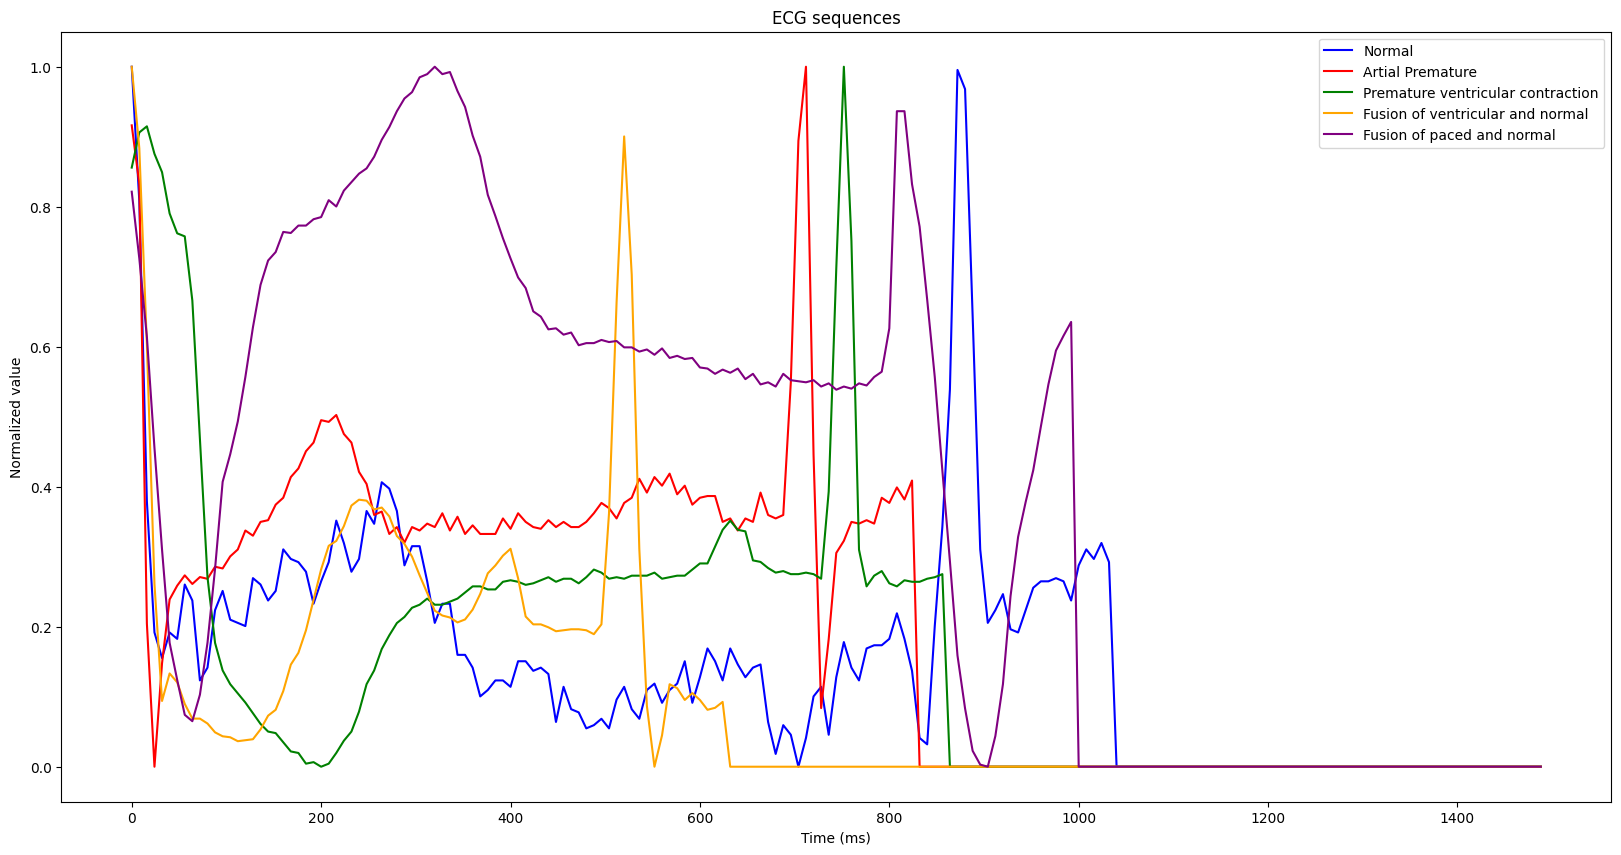

In [249]:
plt.figure(figsize = (20, 10))
for i in range(1):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])  
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [92]:
df_mitbih.label.value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: label, dtype: int64

The data is heavily skewed towards the 0 class, or normal class. So, we're going to upsample all the minority classes

In [93]:
df_mitbih_majority = df_mitbih[df_mitbih.label == 0.0]
df_mitbih_minority1 = df_mitbih[df_mitbih.label == 1.0]
df_mitbih_minority2 = df_mitbih[df_mitbih.label == 2.0]
df_mitbih_minority3 = df_mitbih[df_mitbih.label == 3.0]
df_mitbih_minority4 = df_mitbih[df_mitbih.label == 4.0]

In [94]:
df_mitbih_majority.shape,df_mitbih_minority1.shape, df_mitbih_minority2.shape, df_mitbih_minority3.shape, df_mitbih_minority4.shape, 

((90589, 188), (2779, 188), (7236, 188), (803, 188), (8039, 188))

In [95]:
from sklearn.utils import resample

Now, we're going to up-sample the minority data

In [96]:
df_mitbih_minority1_upsampled = resample(df_mitbih_minority1, 
                                 replace=True,     # sample with replacement
                                 n_samples=45696,    # to match majority class
                                 random_state=123) 

In [97]:
df_mitbih_minority2_upsampled = resample(df_mitbih_minority2, 
                                 replace=True,     # sample with replacement
                                 n_samples=45696,    # to match majority class
                                 random_state=123) 

In [98]:
df_mitbih_minority3_upsampled = resample(df_mitbih_minority3, 
                                 replace=True,     # sample with replacement
                                 n_samples=45696,    # to match majority class
                                 random_state=123) 

In [99]:
df_mitbih_minority4_upsampled = resample(df_mitbih_minority4, 
                                 replace=True,     # sample with replacement
                                 n_samples=45696,    # to match majority class
                                 random_state=123) 

In [100]:
df_mitbih_majority = resample(df_mitbih_majority, 
                                 replace=True,    # sample without replacement
                                 n_samples=45696,     # to match minority class
                                 random_state=123) # reproducible results

In [101]:
#downsampled df_mitbih
df_mitbih_downsampled = pd.concat([df_mitbih_majority, df_mitbih_minority1_upsampled, df_mitbih_minority2_upsampled, df_mitbih_minority3_upsampled, df_mitbih_minority4_upsampled])

In [102]:
df_mitbih_downsampled.label.value_counts()

0.0    45696
1.0    45696
2.0    45696
3.0    45696
4.0    45696
Name: label, dtype: int64

In [103]:
X = df_mitbih_downsampled.drop('label', axis=1)
#X = df_ptbd["RR_interval"]
y = df_mitbih_downsampled['label']

In [104]:
X = X.values
y = y.values

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

In [106]:
#training-validation split goes here
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=20)

In [107]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_val = torch.FloatTensor(X_val)

#labels of regular/irregular heartbeats are 0…4 respectively
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
y_val = torch.LongTensor(y_val)

In [108]:
from torch import nn

In [109]:
flatten = nn.Flatten()

In [110]:
class ConvNet(nn.Module):
  def __init__(self, in_features=2944):
    super().__init__() #this instantiates nn.Module
    self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1,) #output length = 186
    self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1,)
    self.fc1 = nn.Linear(in_features, 128)
    self.dropout1 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(128,80)
    self.dropout2 = nn.Dropout(0.2)
    self.fc3 = nn.Linear(80, 30)
    self.dropout3 = nn.Dropout(0.2)
    self.out = nn.Linear (30, 5)
    
    
  def forward_prop(self, a):
    #print(a.shape)
    a = self.conv1(a)
    a = self.pool1(a)
    #a = self.conv2(a)
    a = flatten(a)
    a = F.relu(self.fc1(a)) #forward prop through layer 1
    a = self.dropout1(a)
    a = F.relu(self.fc2(a))
    #a = self.dropout2(a)
    a = F.relu(self.fc3(a))
    a = self.dropout3(a)
    a = self.out(a)
    return a

In [111]:
#initialises the model with a particular set of random weights and biases
torch.manual_seed(41)
#create an instance of out model
model = ConvNet()

In [112]:
#set the cost function of the model
#in this case the loss function is CrossEntropyLoss
loss_function = nn.CrossEntropyLoss()
#chose the type of gradient descent/optimisation algorithm
#using an 'Adam' optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.0016)

In [113]:
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from sklearn import metrics

In [114]:
#train the model
#1 Epoch: one run through all training data in the network
epochs = 5
#losses array keeps track of accuracy as we improve the network
epochs_list = []
#performing stochastic optimisation

# Create a dataset and data loader
dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

correct = 0
total = 0
last_prediction = []
last_mini_batch = []
plt.figure()
for epoch in range(epochs):
    average_losses = []
    average_loss = 0.0
    for mini_batch_X, mini_batch_y in data_loader:
        # Forward propagation
        
        mini_batch_X = mini_batch_X.unsqueeze(1)
        a = model.forward_prop(mini_batch_X)
        
        _, predicted = torch.max(a, 1)
        
        total += mini_batch_y.size(0)
        correct += (predicted==mini_batch_y).sum().item()
        
        # Measures the loss for the output activation and the label
        loss = loss_function(a, mini_batch_y)
        average_loss += loss.item()
        
        print(f"Epoch: {epoch}, loss: {loss.item()}")
        
        #Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        last_mini_batch.append(mini_batch_y)
        last_prediction.append(predicted)
        
    average_losses.append(average_loss/len(data_loader))
    epochs_list.append(average_losses)

print("training accuracy: ", ((correct/total)*100))
    


Epoch: 0, loss: 1.6272609233856201
Epoch: 0, loss: 1.6141211986541748
Epoch: 0, loss: 1.599360704421997
Epoch: 0, loss: 1.5917816162109375
Epoch: 0, loss: 1.6541370153427124
Epoch: 0, loss: 1.5618547201156616
Epoch: 0, loss: 1.5891053676605225
Epoch: 0, loss: 1.6014742851257324
Epoch: 0, loss: 1.5863277912139893
Epoch: 0, loss: 1.5886707305908203
Epoch: 0, loss: 1.62294602394104
Epoch: 0, loss: 1.515702247619629
Epoch: 0, loss: 1.5658555030822754
Epoch: 0, loss: 1.5087668895721436
Epoch: 0, loss: 1.5301611423492432
Epoch: 0, loss: 1.4379549026489258
Epoch: 0, loss: 1.513036847114563
Epoch: 0, loss: 1.4580919742584229
Epoch: 0, loss: 1.4056955575942993
Epoch: 0, loss: 1.4419418573379517
Epoch: 0, loss: 1.3103582859039307
Epoch: 0, loss: 1.4194023609161377
Epoch: 0, loss: 1.324530839920044
Epoch: 0, loss: 1.3219702243804932
Epoch: 0, loss: 1.2817299365997314
Epoch: 0, loss: 1.333113193511963
Epoch: 0, loss: 1.229500651359558
Epoch: 0, loss: 1.3667254447937012
Epoch: 0, loss: 1.3914978504

<Figure size 640x480 with 0 Axes>

In [115]:
confusion_matrices = []
for (y, a) in zip(last_mini_batch, last_prediction):
    conf_matrix = confusion_matrix(y, a)
    confusion_matrices.append(conf_matrix)

confusion_matrices = np.asarray(confusion_matrices)
confusion_matrices.shape

/var/folders/n7/wfq6fwz52p365xbc0vd0ts7c0000gn/T/ipykernel_5432/1995602841.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  confusion_matrices = np.asarray(confusion_matrices)


(9375,)

Building a cumulative confusion matrix for the model, we see some very confusing insights

Since the confusion matrix is over batches, we create a numpy array that sums over all the corresponding values into a single matrix

In [132]:
test_cm = torch.arange(25)
test_cm = test_cm.reshape(5, 5)

Cell below sums over all confusion matrices in the correct order

In [133]:
i_sum = 0
for j in range(4): #traverse row
  for i in range(4): #traverse column
    for k in range(len(confusion_matrices)): #traverse matrix
      #print(confusion_matrices[k].shape)
      i_sum += confusion_matrices[k][j][i]
    test_cm[j][i] = i_sum
    i_sum = 0

test_cm

tensor([[ 96989,  10096,   4449,   6075,      4],
        [ 13885, 100296,   2533,   1487,      9],
        [  5081,   1892, 105489,   5634,     14],
        [  4079,    583,   3255, 111951,     19],
        [    20,     21,     22,     23,     24]])

The confusion matrix makes no sense: we're supposed to have less than 45,000 examples per class: the data is heavily skewed

In [151]:
i = 0
for row in test_cm:
  print(f"recall for class {i}: {100*(row[i]/torch.sum(row))}%")
  print(f"Number of samples of class {i} are {torch.sum(row)}")
  print()
  i+=1
#479,808

recall for class 0: 82.46452331542969%
Number of samples of class 0 are 117613

recall for class 1: 84.84561157226562%
Number of samples of class 1 are 118210

recall for class 2: 89.31420135498047%
Number of samples of class 2 are 118110

recall for class 3: 93.38043212890625%
Number of samples of class 3 are 119887

recall for class 4: 21.81818199157715%
Number of samples of class 4 are 110



cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = test_cm, display_labels = [0, 1, 2, 3, 4])
cm_display.plot()
plt.show()

[[0.55320162 0.32603822 0.2659979  0.22762058 0.19895318]]


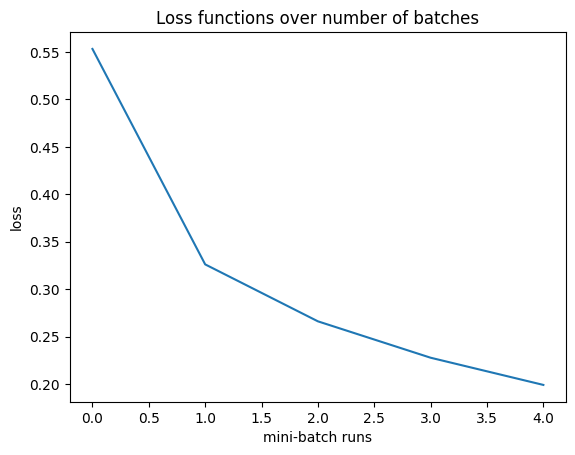

In [135]:
#to see all graphs in a single figure
epoch_losses_np = np.array(epochs_list)
epoch_losses_np = epoch_losses_np.reshape(1, -1)
print(epoch_losses_np)
for epoch in epoch_losses_np:
  plt.plot(range(len(epoch)), epoch)
  plt.ylabel("loss")
  plt.xlabel("mini-batch runs")
  plt.title("Loss functions over number of batches")
  plt.show()

In [136]:
#evaluate the accuracy on the validation data
def evaluate(model, loader):
  model.eval()
  correct = 0
  total = 0
  
  with torch.no_grad():
    plt.figure()
    last_predicted = []
    last_batch = []
    for inputs, targets in loader:
      a = model.forward_prop(inputs)
      _, predicted = torch.max(a, 1)
      total += targets.size(0)
      correct += (predicted==targets).sum().item()
      last_batch = targets
      last_predicted = predicted
    conf_matrix = confusion_matrix(last_batch, last_predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0, 1, 2, 3, 4])
    cm_display.plot()
    plt.show()
  
  return (correct/total)*100
      

<Figure size 640x480 with 0 Axes>

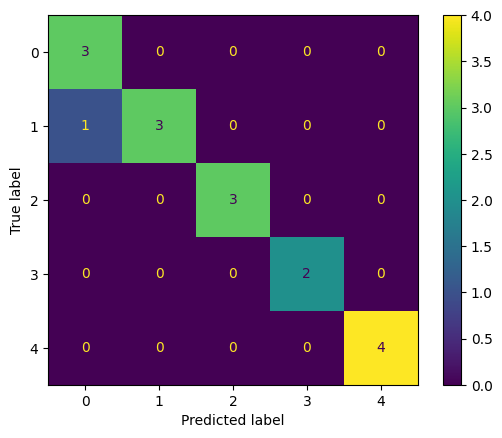

In [137]:
X_val = X_val.reshape(-1, 187)
X_val = X_val.unsqueeze(1)
validation_data_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=True)
validation_accuracy = evaluate(model, validation_data_loader)

In [138]:
print(validation_accuracy)

95.1661220043573


In [139]:
X_test = X_test.squeeze(1)

In [140]:
X_test = X_test.unsqueeze(1)

In [141]:
X_test.shape

torch.Size([57120, 1, 187])

<Figure size 640x480 with 0 Axes>

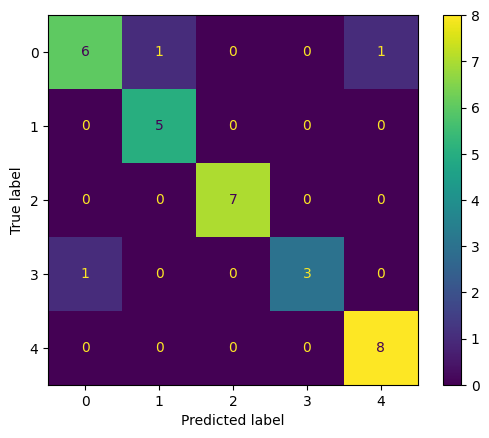

In [142]:
test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)
test_accuracy = evaluate(model, test_data_loader)

In [143]:
print(test_accuracy)

95.22584033613445


Model 2: alternate implementation using FFTs

In [177]:
X_train.shape

torch.Size([119952, 187])

Before FFT

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


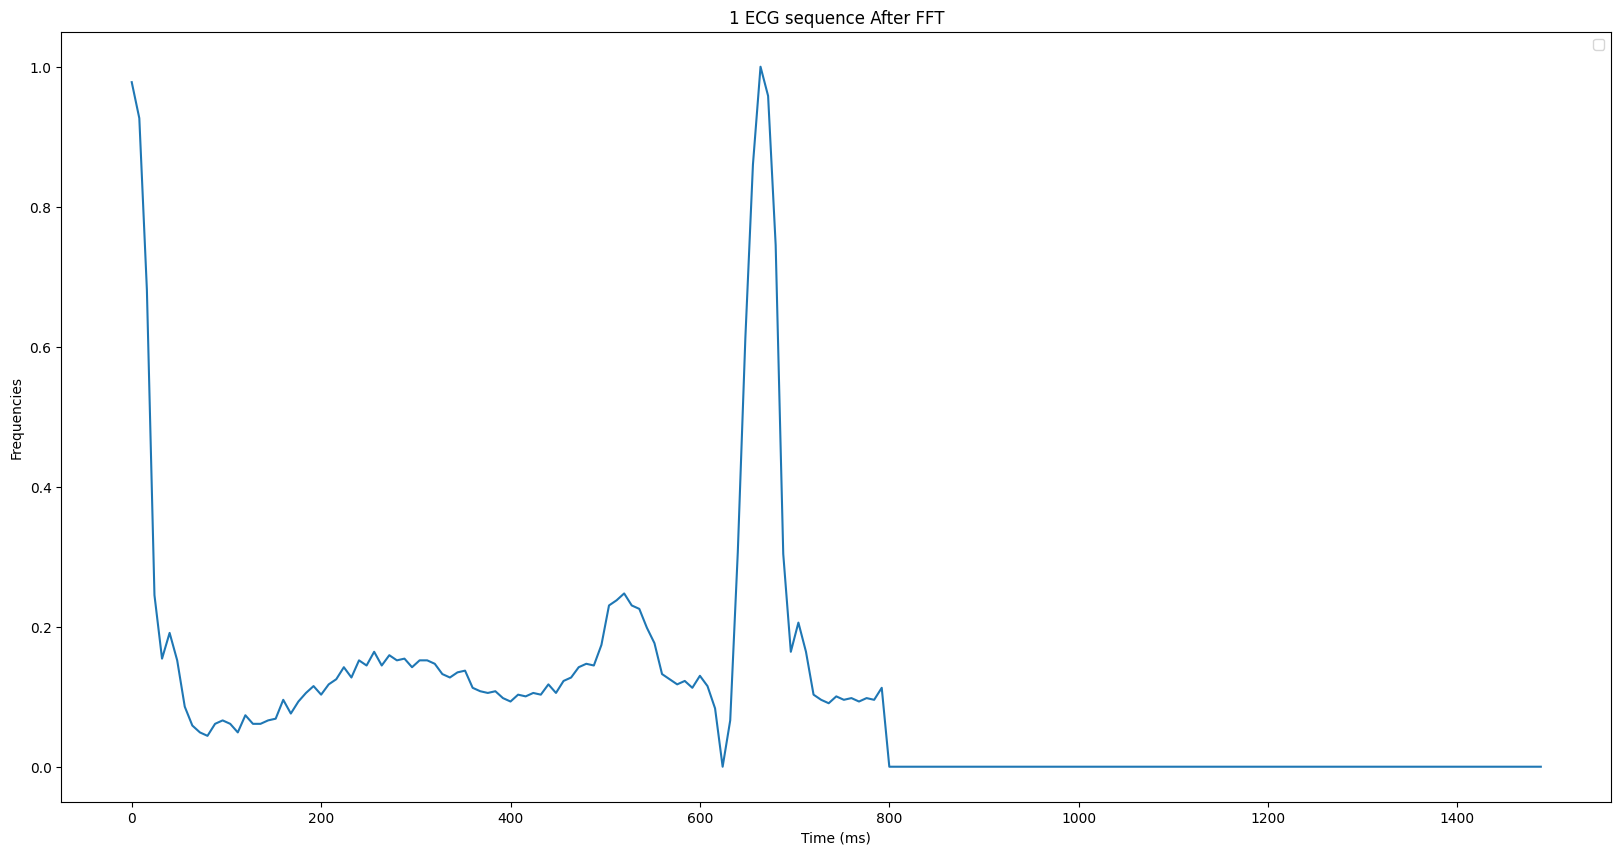

In [267]:
plt.figure(figsize = (20, 10))
# define colors for each class

x = df_mitbih.columns[:-1] #187 time values
y = df_mitbih.iloc[0, :-1]
label = df_mitbih
plt.plot(x, y)
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("1 ECG sequence After FFT")
# y lable is "Normalized value"
plt.ylabel("Frequencies")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [178]:
X_train[0][:5]

tensor([6539202.5000, 2710954.5000, 1749561.6250,  744862.8750,  337786.8125])

We could collect PSD features from the wave, feed PSD frequencies' amplitudes as features into a network, then classify into different types of arrythmias based on those features